# Advance Lane Lines

## Import all the necessary libraries

In [1]:
import time
import glob
import collections
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

## Utils

In [2]:
def region_of_interest(img, vertices):
    """Applies an image mask."""
    
    # define a blank mask
    mask = np.zeros_like(img)   
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]  
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def warp_image(img, src, dst, size):
    """Perspective."""
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warp_img = cv2.warpPerspective(img, M, size, flags=cv2.INTER_LINEAR)
    return warp_img, M, Minv

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """Draw hough lines."""
    
    if lines is None:
        return img
    
    left_lines = []
    right_lines = []
    
    # filter horizontal lines and
    # separate line segments into right and left
    for line_lists in lines:
        for line in line_lists:
            slope = _calc_slope(line)
            if slope is not None and 0.5 < abs(slope) < 2.0:
                if slope > 0:
                    right_lines.append(line)
                else:
                    left_lines.append(line)
    
    # calculate average of line segments
    right_line = _average_lines(right_lines, img.shape)
    left_line = _average_lines(left_lines, img.shape)
    if right_line is not None:
        x1, y1, x2, y2 = right_line
        cv2.line(img, (x1, y1), (x2, y2), color, thickness) 
    if left_line is not None:
        x1, y1, x2, y2 = left_line
        cv2.line(img, (x1, y1), (x2, y2), color, thickness) 

def _calc_slope(line):
    x1, y1, x2, y2 = line
    if x2 == x1:  # devide by zero
        return None
    else:
        return (y2 - y1) / (x2 - x1)

def _calc_length(line):
    """Calculates length of line segment"""
    x1, y1, x2, y2 = line
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)
    
def _calc_intercept(line, slope):
    """ Calculates the intercept of line cy = slope * cx + intercept 
        where cx, cy in the center of the line
    """
    x1, y1, x2, y2 = line
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    return cy - (slope * cx)

def _average_lines(lines, img_shape):
    """ Calculate the weighted average of lines
        and extrapolate line to bottom of image
    """
    if lines is None or len(lines) == 0:
        return None
    
    #########################################################
    # Or You can use cv2.fitLine() to instead.
    
    # length of lines
    weights = [_calc_length(l) for l in lines]   
    
    # slope of lines
    slopes = [_calc_slope(l) for l in lines]
    
    # calculate the weighted average of lines
    weighted_slope_sum = np.inner(slopes, weights)
    avg_slope = weighted_slope_sum / sum(weights)
    
    intercepts = [_calc_intercept(l, avg_slope) for l in lines]
    weighted_intercepts_sum = np.inner(intercepts, weights)
    avg_intercept = weighted_intercepts_sum / sum(weights)
    #########################################################

    # now we have our line y = avg_slope * x + avg_intercept
    # we extrapolate our line to botton of image
    # and no more upper than region of interest
    width, height, depth = img_shape
    y1 = width / 1.65
    x1 = (y1 - avg_intercept) / avg_slope
    y2 = width
    x2 = (y2 - avg_intercept) / avg_slope
    
    return [int(x1), int(y1), int(x2), int(y2)]
      
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(origin_img, hough_img, a=0.8, b=1., r=0.):
    # origin_img * α + hough_img * β + γ
    return cv2.addWeighted(origin_img, a, hough_img, b, r)

## Canny

In [3]:
def grayscale(img):
    """Convert an image into Grayscale."""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def gaussian_blur(img, kernel_size=5):
    """Applies a Gaussian Noise kernel."""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def canny(img, low_threshold, high_threshold, apertureSize, L2gradient):
    """Applies the Canny transform."""
    return cv2.Canny(img, low_threshold, high_threshold, apertureSize=apertureSize, L2gradient=L2gradient)

def run_canny(img, blur_kernel=5, low_thresh=50, high_thresh=150, apertureSize=3, L2gradient=False):
    # Convert an image into grayscale
    gray = grayscale(img)
    
    # Apply a Gaussian Blur
    blur_img = gaussian_blur(gray, blur_kernel)

    # Run the canny edge detection
    canny_img = canny(blur_img, low_thresh, high_thresh, apertureSize, L2gradient)

    return canny_img

## Sobel

In [4]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def calc_sobel(img, sx=False, sy=False, sobel_kernel=5, thresh=(20, 200)):
    # Convert to grayscale - sobel can only have one color channel
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take the sobel gradient in x and y
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    if sx:
        abs_sobel = np.absolute(sobel_x)
        scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    elif sy:
        abs_sobel = np.absolute(sobel_y)
        scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    else:
        # Calculate the magnitude 
        mag_sobel = np.sqrt(np.square(sobel_x) + np.square(sobel_y))
    
        # Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scaled_sobel = np.uint8(255 * mag_sobel / np.max(mag_sobel))
    
    # Create a binary mask where mag thresholds are me
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1   

    return sobel_binary

## Canny VS. Sobel

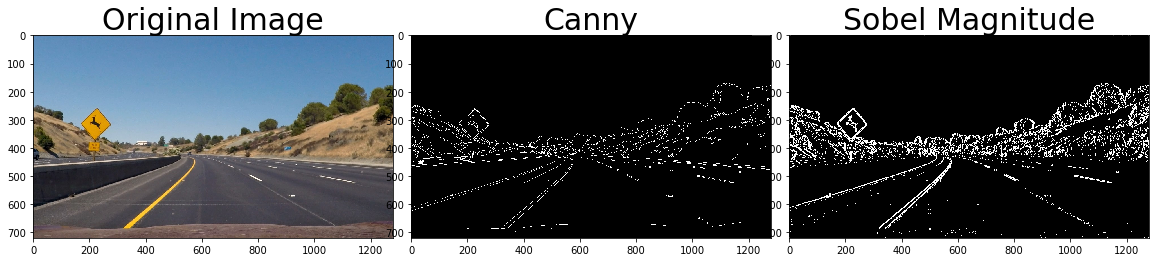

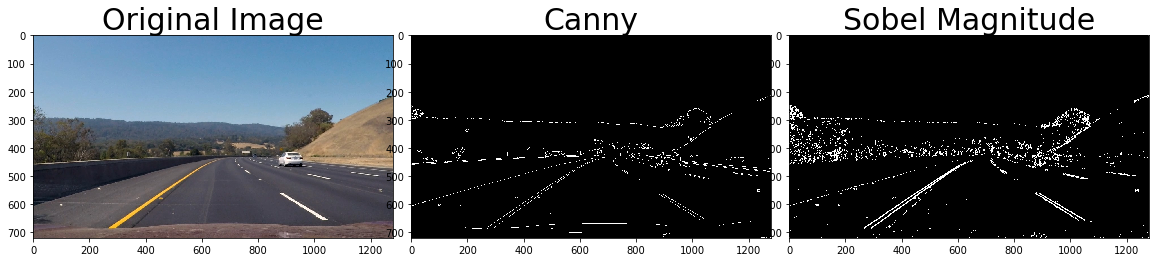

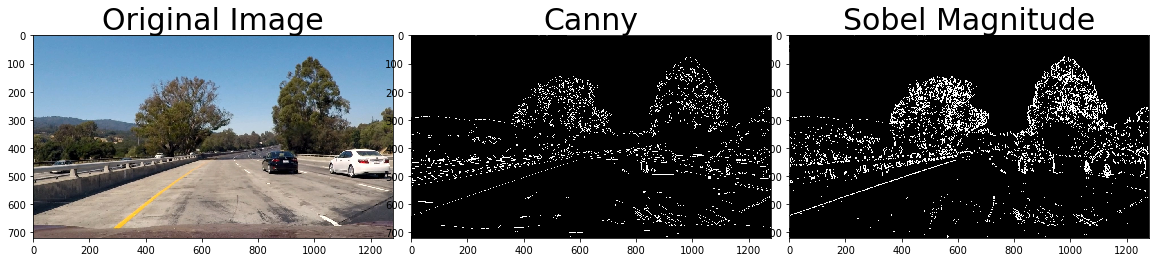

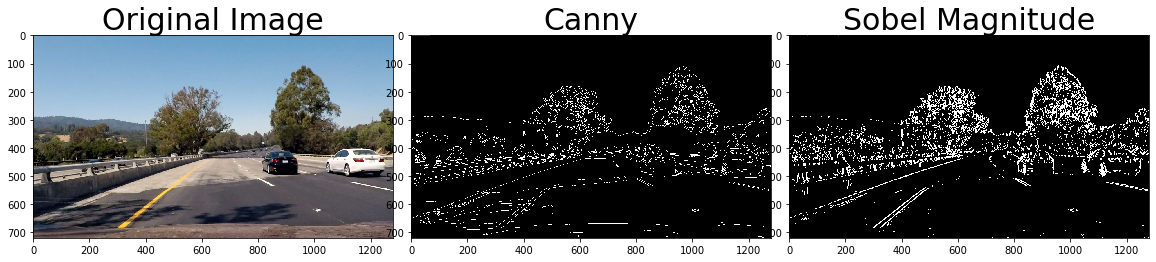

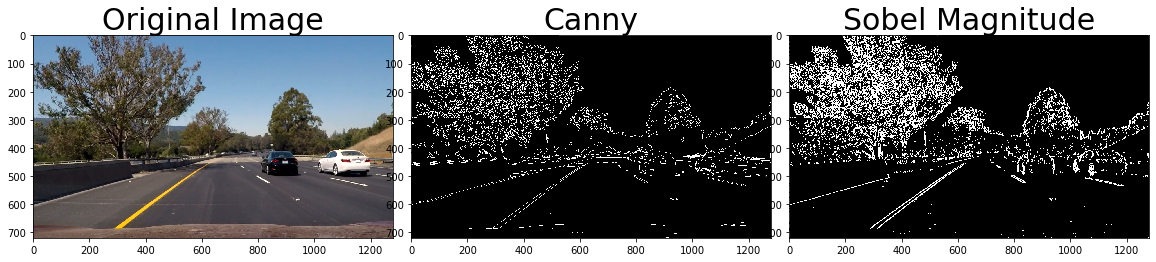

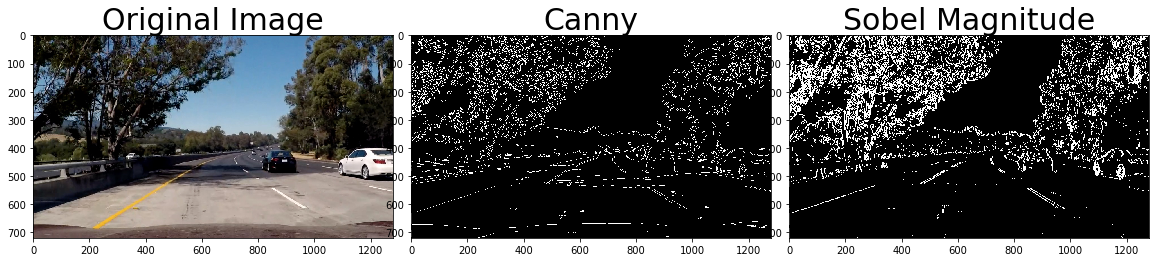

In [5]:
images = glob.glob('test_imgs/test*.jpg')

for fname in images:
    img = mpimg.imread(fname)
    
    sobel_img = calc_sobel(img, sx=True, thresh=(20, 200))
    canny_img = run_canny(img, blur_kernel=5, low_thresh=50, high_thresh=150)

    # Visualize result
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(canny_img, cmap='gray')
    ax2.set_title('Canny', fontsize=30)
    ax3.imshow(sobel_img, cmap='gray')
    ax3.set_title('Sobel Magnitude', fontsize=30)

## Color Selection Functions

Apply threshold funciton to take a channel and a threshold and return the binary image

In [6]:
def applyThreshold(channel, threshold):
    # Create an image of all zeros
    binary_output = np.zeros_like(channel)
    
    # Apply a threshold to the channel with inclusive thresholds
    binary_output[(channel >= threshold[0]) & (channel <= threshold[1])] = 1
    
    return binary_output

# The threshold of R-channel of RGB
def rgb_r_thresh(img, thresh=(125,255)):
    # Pull out the R channel - assuming that RGB was passed in
    channel = img[:,:,0]
    
    # Return the applied threshold binary image
    return applyThreshold(channel, thresh)

# The threshold of S-channel of HLS
def hls_s_thresh(img, thresh=(125,255)):
    # Convert to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Pull out the S cahnnel
    channel = hls[:,:,2]
    
    # Return the applied threshold binary image
    return applyThreshold(channel, thresh)

# The threshold of B-channel of LAB
def lab_b_thresh(img, thresh=(125,255)):
    # Convert to LAB
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    
    # Pull out the B channel
    channel = lab[:,:,2]
    
    # Return the applied threshold binary image
    return applyThreshold(channel, thresh)

# The threshold of L-channel of LUV
def luv_l_thresh(img, thresh=(125,255)):
    # Convert to LUV
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
    # Pull out the L channel
    channel = luv[:,:,0]
    
    # Return the applied threshold binary image
    return applyThreshold(channel, thresh)

## Binary Pipeline Function

This function will process an image and return the binary image

- Edge Detection: Use `Sobel`


In [7]:
def binary_pipeline(img, sx=True, sy=False, 
                    sobel_kernel_size=7, sobel_thresh_low=35, sobel_thresh_high=50, 
                    canny_blur_size=5 , canny_thresh_low=50, canny_thresh_high=150, 
                    r_thresh_low=225, r_thresh_high=255, 
                    s_thresh_low=220, s_thresh_high=250,
                    b_thresh_low=175, b_thresh_high=255, 
                    l_thresh_low=215, l_thresh_high=255, 
                    show_images=False):
    # Color Selection
    r = rgb_r_thresh(img, thresh=(r_thresh_low, r_thresh_high))
    s = hls_s_thresh(img, thresh=(s_thresh_low, s_thresh_high))
    b = lab_b_thresh(img, thresh=(b_thresh_low, b_thresh_high))
    l = luv_l_thresh(img, thresh=(l_thresh_low, l_thresh_high))
    
    # edge detection
    edge = calc_sobel(img, sx=sx, sobel_kernel=sobel_kernel_size, thresh=(sobel_thresh_low, sobel_thresh_high))

    # combine these layers
    combined_binary = np.zeros_like(s)
    combined_binary[(r == 1) | (s == 1) | (b == 1) | (l == 1) | (edge == 1)] = 1
    
    # Create plots if we want them
    if show_images:
        f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(20, 10))
        f.tight_layout()

        ax1.set_title('original', fontsize=15)
        ax1.axis('off')
        ax1.imshow(img)
        ax2.set_title('RGB - R', fontsize=15)
        ax2.axis('off')
        ax2.imshow(r, cmap='gray')
        ax3.set_title('HLS - S', fontsize=15)
        ax3.axis('off')
        ax3.imshow(s, cmap='gray')
        ax4.set_title('LAB - B', fontsize=15)
        ax4.axis('off')
        ax4.imshow(b, cmap='gray')
        ax5.set_title('LUV - L', fontsize=15)
        ax5.axis('off')
        ax5.imshow(l, cmap='gray')
        ax6.set_title('Sobel', fontsize=15)
        ax6.axis('off')
        ax6.imshow(edge, cmap='gray')
        
    return combined_binary

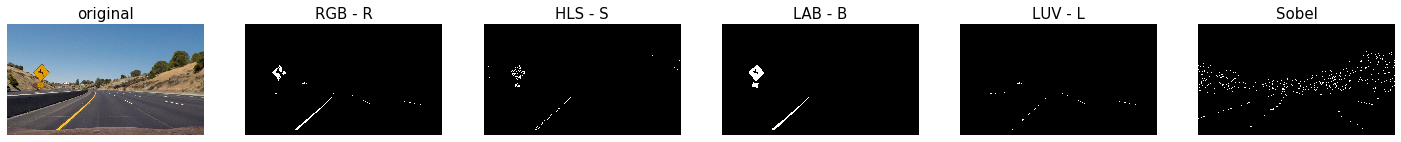

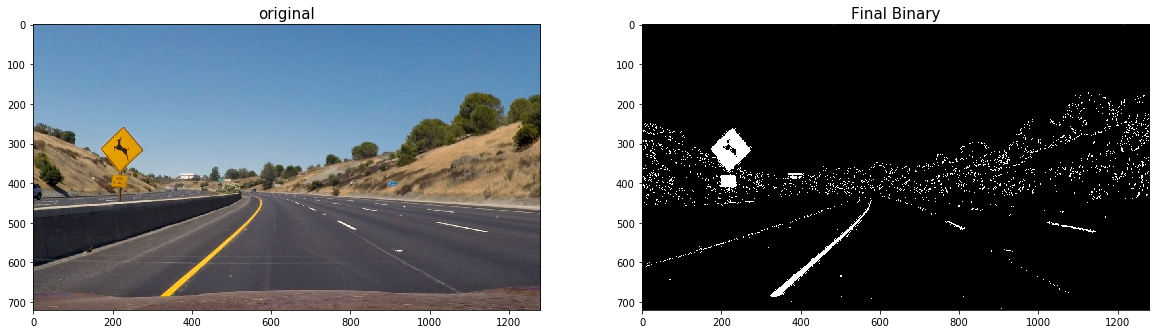

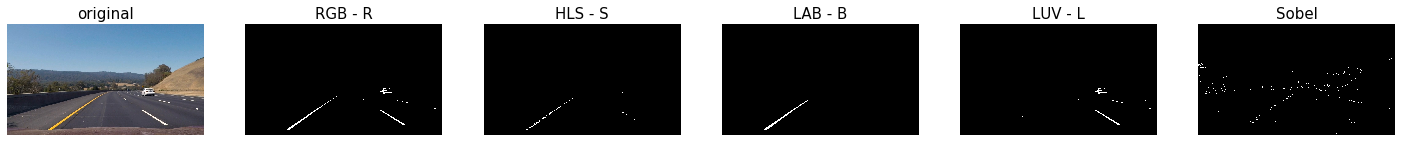

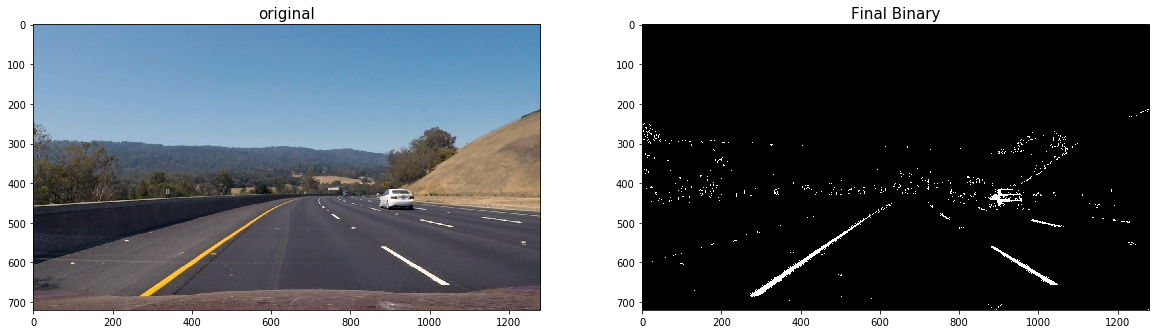

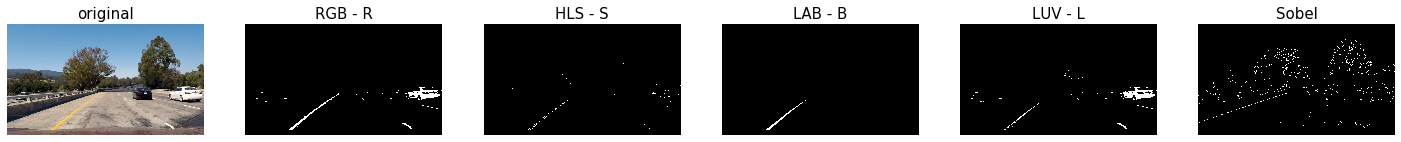

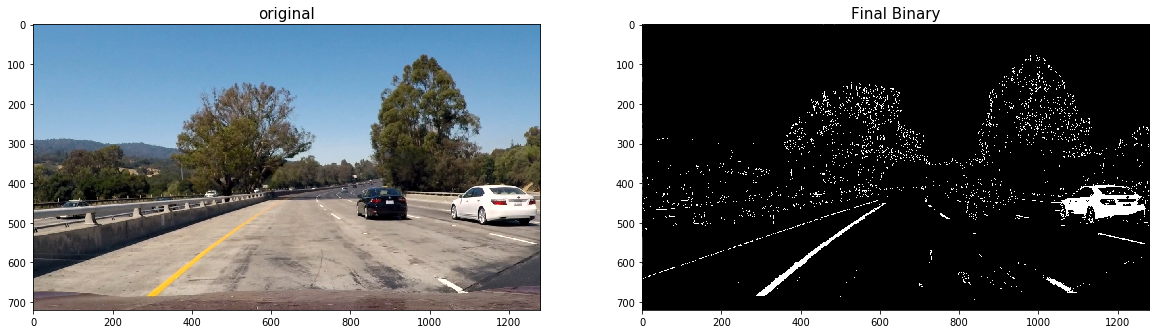

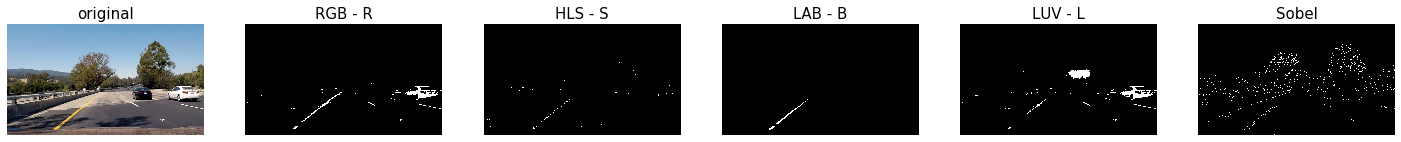

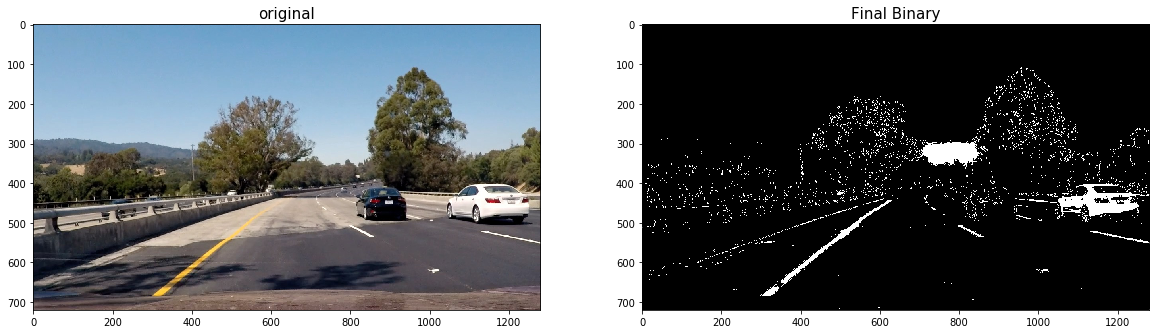

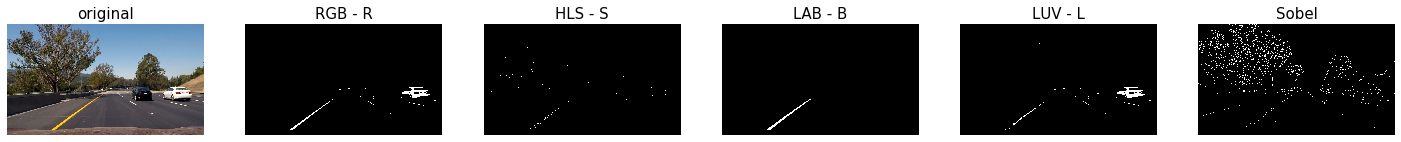

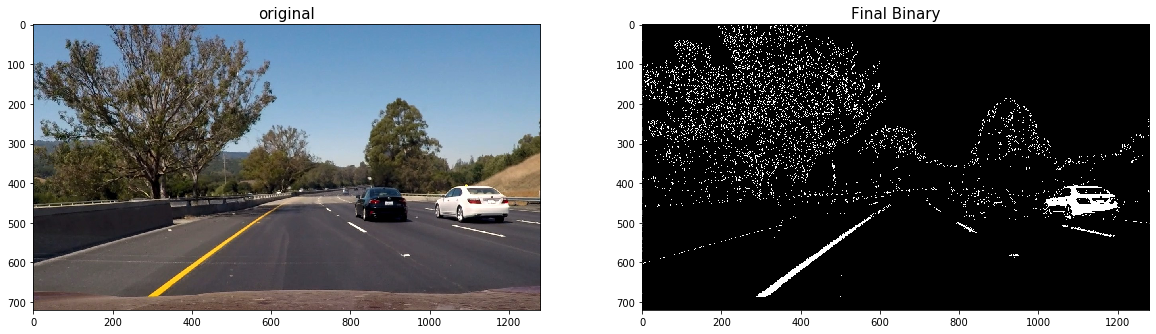

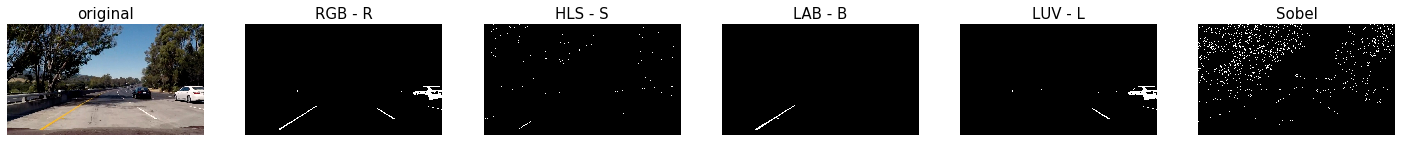

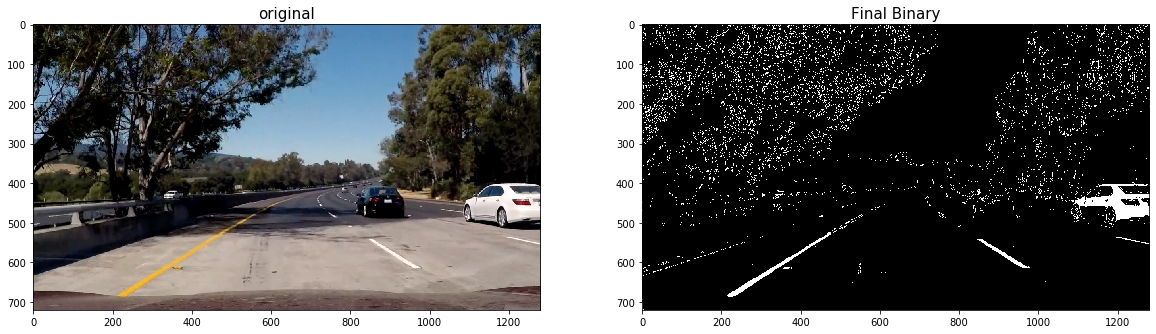

In [8]:
images = glob.glob('test_imgs/test*.jpg')

for fname in images:
    img = mpimg.imread(fname)
    
    combined = binary_pipeline(img, show_images=True)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title('original', fontsize=15)
    ax1.imshow(img)
    ax2.set_title('Final Binary', fontsize=15)
    ax2.imshow(combined, cmap='gray')

## Setting all the necessary parameters

In [9]:
# We use a fixed image size: (720, 480)
size = (720, 480)

# crop images: (720, 180)
(x, y) = (0, 300)
(w, h) = (720, 180)

# ROI (need to be changed when using different camera)
ROI = [[(100, h), (150, 50), (500, 50), (600, h)]]

# Perspective
# Cordinates of the 4 corners if the original image
src = np.float32([(100, 180), (300, 75), (400, 75), (520, 180)])
# Cordinates of the 4 corners if the desired output
dst = np.float32([(200, 180), (200, 0), (500, 0), (500, 180)])

# canny
canny_blur_size = 5
canny_thresh_low = 50
canny_thresh_high = 150

# sobel
sobel_kernel_size = 5
sobel_thresh_low = 20
sobel_thresh_high = 200

############################
# hough 
rho = 1       
theta = np.pi/180 

# hough parameters for canny
threshold = 30    
min_line_len = 30
max_line_gap = 50

# hough parameters for sobel
# threshold = 30    
# min_line_len = 30
# max_line_gap = 50
############################

# add weighted
a = 0.8
b = 1
r = 0

## Start to detect lane lines

In [10]:
# Read video
cap = cv2.VideoCapture('test_video/test_video.mp4')

while True:
    start = time.time()
    ret, frame = cap.read() 
    
    if ret:
        img = cv2.resize(frame, size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # We use an image that after cropped to detect lane line.
        crop_img = img[y:y+h, x:x+w]

        # edge detection
        #binary_edge = run_canny(crop_img)
        binary_edge = binary_pipeline(crop_img)

        # ROI (need to be changed when using different camera)
        # vertices = np.array(ROI, dtype=np.int32)
        # roi_img = region_of_interest(binary_edge, vertices)

        hough_img = hough_lines(binary_edge, rho, theta, threshold, min_line_len, max_line_gap)
        result_img = weighted_img(crop_img, hough_img) #(original_image, hough_image)
        img[y:y+h, x:x+w] = result_img

        sub_frame1 = cv2.resize(crop_img, (100,100), interpolation=cv2.INTER_CUBIC)
        img[0:100,280:380] = sub_frame1
        
        sub_frame2 = cv2.resize(binary_edge, (100,100), interpolation=cv2.INTER_CUBIC)
        img1 = np.zeros_like(sub_frame1)
        img1[:,:,0] = sub_frame2 * 1000
        img1[:,:,1] = 0
        img1[:,:,2] = 0
        img[0:100,390:490] = img1
        
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
        fps  = "Fps: {:.2f}".format(1 / (time.time() - start))
        cv2.putText(img, fps, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.imshow("Lane lines detection", img)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

cap.release()
cv2.destroyAllWindows()